# How to use Multiple Devices
## Solving Equilibrium

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

In [2]:
num_device = 4
from desc import set_device, _set_cpu_count

_set_cpu_count(num_device)
set_device("cpu", num_device=num_device)

In [3]:
import numpy as np

from desc.examples import get
from desc.objectives import *
from desc.objectives.getters import *
from desc.grid import LinearGrid
from desc.backend import jnp
from desc.plotting import plot_grid
from desc.backend import jax
from desc.optimize import Optimizer

DESC version 0.13.0+1539.gb6b43370b.dirty,using JAX backend, jax version=0.4.38, jaxlib version=0.4.38, dtype=float64
Using 4 CPUs:
	 CPU 0: TFRT_CPU_0 with 6.26 GB available memory
	 CPU 1: TFRT_CPU_1 with 6.26 GB available memory
	 CPU 2: TFRT_CPU_2 with 6.26 GB available memory
	 CPU 3: TFRT_CPU_3 with 6.26 GB available memory


In [4]:
eq = get("HELIOTRON")
eq.change_resolution(3, 3, 3, 6, 6, 6)

/home/yigit/Codes/DESC/desc/utils.py:560: UserWarning: Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`
  warnings.warn(colored(msg, "yellow"), err)


In [5]:
obj = get_parallel_forcebalance(eq, num_device=num_device)
cons = get_fixed_boundary_constraints(eq)
for obji in obj.objectives:
    print(obji._device)

Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms


/home/yigit/Codes/DESC/desc/utils.py:560: UserWarning: 
When using multiple devices, the ObjectiveFunction will run each 
sub-objective on the device specified in the sub-objective. 
Setting the deriv_mode to 'blocked' to ensure that each sub-objective 
runs on the correct device.
  warnings.warn(colored(msg, "yellow"), err)


None
TFRT_CPU_1
TFRT_CPU_2
TFRT_CPU_3


In [6]:
eq.solve(objective=obj, constraints=cons, maxiter=1, ftol=0, gtol=0, xtol=0, verbose=3)

Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 1.53 sec
Timer: Linear constraint projection build = 3.80 sec
Number of parameters: 76
Number of objectives: 2704
Timer: Initializing the optimization = 5.36 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          8.573e+06                                    4.135e+03   
       1              2          7.294e+05      7.844e+06      5.352e-01      6.490e+02   
         Current function value: 7.294e+05
         Total delta_x: 5.352e-01
         Iterations: 1
    

(Equilibrium at 0x7e5726b83f50 (L=3, M=3, N=3, NFP=19, sym=True, spectral_indexing=fringe),
     message: Maximum number of iterations has been exceeded.
     success: False
         fun: [-9.316e-05 -9.293e-05 ...  2.140e-02 -4.778e-03]
           x: [-2.477e-02 -1.206e-01 ...  7.442e-03  1.768e-01]
         nit: 1
        cost: 729415.2017973666
           v: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
  optimality: 649.0096310587396
        nfev: 2
        njev: 2
        allx: [Array([-3.392e-05,  8.921e-06, ...,  0.000e+00,  0.000e+00],      dtype=float64), Array([ 2.416e-05,  1.501e-03, ...,  0.000e+00,  0.000e+00],      dtype=float64)]
       alltr: [Array( 1.402e+06, dtype=float64), np.float64(1401525.8219770438)]
     history: [[{'R_lmn': Array([-3.392e-05,  8.921e-06, ...,  0.000e+00,  1.850e-05],      dtype=float64), 'Z_lmn': Array([ 9.011e-06,  1.167e-05, ..., -3.697e-05,  1.686e-05],      dtype=float64), 'L_lmn': Array([-6.194e-07, -1.567e-05, ..., -9.721e-06, -1.466

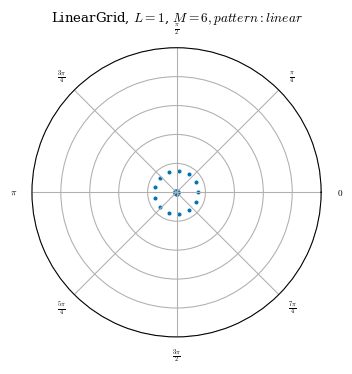

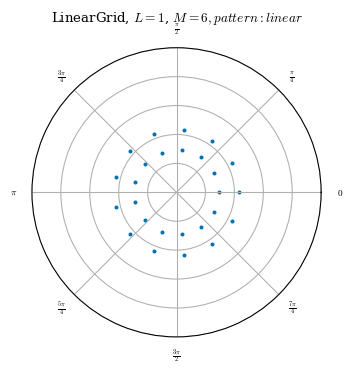

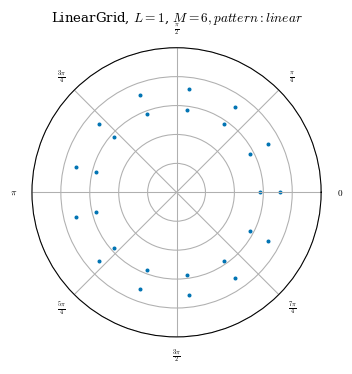

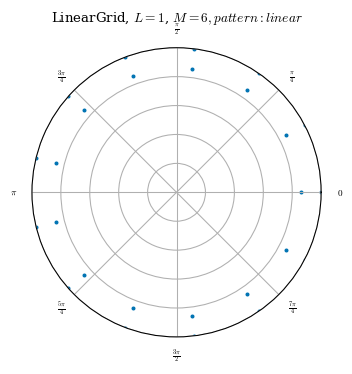

In [7]:
for obji in obj.objectives:
    plot_grid(obji.constants["transforms"]["grid"])

## Using other Objectives
Above we used the convenience function for force balance objective, but we can also other objectives with this approach. There are some extra steps you need to apply though.

In [8]:
eq = get("HELIOTRON")
eq.change_resolution(3, 3, 3, 6, 6, 6)

/home/yigit/Codes/DESC/desc/utils.py:560: UserWarning: Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`
  warnings.warn(colored(msg, "yellow"), err)


In [9]:
grid1 = LinearGrid(
    M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=np.array([0.2, 0.4]), sym=True
)
grid2 = LinearGrid(
    M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=np.array([0.6, 0.8, 1.0]), sym=True
)

obj1 = QuasisymmetryTwoTerm(eq=eq, helicity=(1, eq.NFP), grid=grid1, device_id=0)
obj2 = QuasisymmetryTwoTerm(eq=eq, helicity=(1, eq.NFP), grid=grid2, device_id=1)
obj3 = AspectRatio(eq=eq, target=8, weight=100, device_id=1)

objs = [obj1, obj2, obj3]
for obji in objs:
    obji.build(verbose=3)
    obji = jax.device_put(obji, obji._device)
    obji.things[0] = eq

objective = ObjectiveFunction(objs)
objective.build(verbose=3)

Precomputing transforms
Timer: Precomputing transforms = 606 ms
Precomputing transforms
Timer: Precomputing transforms = 684 ms
Precomputing transforms
Timer: Precomputing transforms = 681 ms
Timer: Objective build = 6.35 ms


In [10]:
k = 1
R_modes = np.vstack(
    (
        [0, 0, 0],
        eq.surface.R_basis.modes[np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :],
    )
)
Z_modes = eq.surface.Z_basis.modes[np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :]
constraints = (
    FixBoundaryR(eq=eq, modes=R_modes),
    FixBoundaryZ(eq=eq, modes=Z_modes),
    FixPressure(eq=eq),
    FixPsi(eq=eq),
)
optimizer = Optimizer("lsq-exact")

In [11]:
eq.optimize(
    objective=objective,
    constraints=constraints,
    optimizer=optimizer,
    maxiter=1,
    verbose=3,
    options={
        "initial_trust_ratio": 1.0,
    },
)

Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 274 ms
Timer: Linear constraint projection build = 1.74 sec
Number of parameters: 97
Number of objectives: 456
Timer: Initializing the optimization = 2.04 sec

Starting optimization
Using method: lsq-exact
This should run on GPU id:0
This should run on GPU id:1
This should run on GPU id:1
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.561e+22                                    1.767e+11   
This should run on GPU id:0
This should run on GPU id:1
This should run on GPU id:1
       1              5          5.466e+21      1.014e+22      2.003e+01      1.046e+11   
         C

(Equilibrium at 0x7e56a13c7140 (L=3, M=3, N=3, NFP=19, sym=True, spectral_indexing=fringe),
     message: Maximum number of iterations has been exceeded.
     success: False
         fun: [ 3.114e-01  9.780e-01 ...  6.524e+02  8.763e+01]
           x: [-1.118e-01  5.238e-02 ...  1.617e+00 -2.211e-01]
         nit: 1
        cost: 5.465705943561737e+21
           v: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
  optimality: 104553392458.05392
        nfev: 5
        njev: 2
        allx: [Array([-3.392e-05,  8.921e-06, ...,  0.000e+00,  0.000e+00],      dtype=float64), Array([-4.503e-05, -1.034e-03, ...,  0.000e+00,  0.000e+00],      dtype=float64)]
       alltr: [Array( 2.307e+16, dtype=float64), np.float64(5767465574622139.0), np.float64(1441866393655534.8), np.float64(360466598413883.75), np.float64(360466598413883.75)]
     history: [[{'R_lmn': Array([-3.392e-05,  8.921e-06, ...,  0.000e+00,  1.850e-05],      dtype=float64), 'Z_lmn': Array([ 9.011e-06,  1.167e-05, ..., -3.697e-

## Optimization using Proximal Method

In [12]:
eq = get("precise_QA")
# eq.change_resolution(12, 12, 12, 24, 24, 24)
eq.change_resolution(3, 3, 3, 6, 6, 6)

/home/yigit/Codes/DESC/desc/utils.py:560: UserWarning: Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`
  warnings.warn(colored(msg, "yellow"), err)


In [13]:
grid1 = LinearGrid(
    M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=jnp.linspace(0.2, 0.5, 4), sym=True
)
grid2 = LinearGrid(
    M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=jnp.linspace(0.6, 1.0, 6), sym=True
)

obj1 = QuasisymmetryTwoTerm(eq=eq, helicity=(1, eq.NFP), grid=grid1, device_id=0)
obj2 = QuasisymmetryTwoTerm(eq=eq, helicity=(1, eq.NFP), grid=grid2, device_id=0)
obj3 = AspectRatio(eq=eq, target=8, weight=100, device_id=0)

objs = [obj1, obj2, obj3]
for obji in objs:
    obji.build(verbose=3)
    obji = jax.device_put(obji, obji._device)
    obji.things[0] = eq

objective = ObjectiveFunction(objs)
objective.build(verbose=3)

Precomputing transforms
Timer: Precomputing transforms = 810 ms
Precomputing transforms
Timer: Precomputing transforms = 1.32 sec
Precomputing transforms
Timer: Precomputing transforms = 407 ms
Timer: Objective build = 5.30 ms


In [14]:
k = 1
R_modes = np.vstack(
    (
        [0, 0, 0],
        eq.surface.R_basis.modes[np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :],
    )
)
Z_modes = eq.surface.Z_basis.modes[np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :]
constraints = (
    ForceBalance(eq=eq),
    FixBoundaryR(eq=eq, modes=R_modes),
    FixBoundaryZ(eq=eq, modes=Z_modes),
    FixPressure(eq=eq),
    FixPsi(eq=eq),
    FixCurrent(eq=eq),
)
optimizer = Optimizer("proximal-lsq-exact")

In [15]:
eq.optimize(
    objective=objective,
    constraints=constraints,
    optimizer=optimizer,
    maxiter=1,
    verbose=3,
    options={
        "initial_trust_ratio": 1.0,
    },
)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 863 ms
Timer: Objective build = 1.08 sec
Timer: Proximal projection build = 4.83 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Timer: Objective build = 232 ms
Timer: Linear constraint projection build = 1.11 sec
Number of parameters: 8
Number of objectives: 911
Timer: Initializing the optimization = 6.23 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.011e+04                                    1.952e+02   
       1              4          8.735e+03      1.138e+04      4.838e-02      1.104e+02   
         Current function value: 8.735e+03
         Total delta_x: 4.838e-02
         Iterations: 1
         Function evaluations: 4
         Jacobian evaluations: 2
T

(Equilibrium at 0x7e5688ede8a0 (L=3, M=3, N=3, NFP=2, sym=True, spectral_indexing=ansi),
     message: Maximum number of iterations has been exceeded.
     success: False
         fun: [-6.669e-02 -1.838e-01 ...  1.709e-01 -1.291e+02]
           x: [-2.124e-01  1.388e-01  1.794e-01 -7.720e-02 -1.261e-01
                4.834e-02 -2.327e-01 -1.485e-01]
         nit: 1
        cost: 8735.080665954583
           v: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
                1.000e+00  1.000e+00  1.000e+00]
  optimality: 110.41872641325968
        nfev: 4
        njev: 2
        allx: [Array([ 0.000e+00,  0.000e+00, ...,  1.082e-03, -2.543e-03],      dtype=float64), Array([ 0.000e+00,  0.000e+00, ...,  1.082e-03, -2.543e-03],      dtype=float64)]
       alltr: [Array( 5.665e+02, dtype=float64), np.float64(130.5803471209196), np.float64(32.6450867802299), np.float64(65.29017356045979)]
     history: [[{'R_lmn': Array([-3.535e-03,  1.627e-03, ...,  5.860e-04,  1.585e-04],      dt